In [1]:
# load some necessary modules
from dmipy.core import modeling_framework
from os.path import join
import numpy as np

/Users/paddyslator/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# load HCP acqusition scheme 
from dmipy.data import saved_acquisition_schemes

acq_scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

In [3]:
#ball stick and spherical mean ball-stick model 
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel,MultiCompartmentModel

stick = cylinder_models.C1Stick()
ball = gaussian_models.G1Ball()

ballstick = MultiCompartmentModel(models=[ball,stick])

from dmipy.distributions.distribute_models import BundleModel
#spherical mean model with tortuosity constraint
bundle = BundleModel([stick, ball])
bundle.set_tortuous_parameter('G1Ball_1_lambda_iso',
    'C1Stick_1_lambda_par','partial_volume_0')

sm_ballstick = MultiCompartmentSphericalMeanModel(
    models=[bundle])

print(ballstick.parameter_names)
print(sm_ballstick.parameter_names)


We highly recommend installing pathos to take advantage of multicore processing.
We highly recommend installing pathos to take advantage of multicore processing.
['G1Ball_1_lambda_iso', 'C1Stick_1_lambda_par', 'C1Stick_1_mu', 'partial_volume_0', 'partial_volume_1']
['BundleModel_1_partial_volume_0', 'BundleModel_1_C1Stick_1_lambda_par']


In [4]:
ballstick = MultiCompartmentModel(models=[ball,stick])
stickball = MultiCompartmentModel(models=[stick,ball])
print(ballstick.parameter_names)
print(stickball.parameter_names)
print(ballstick.parameter_cardinality)
print(stickball.parameter_cardinality)

We highly recommend installing pathos to take advantage of multicore processing.
We highly recommend installing pathos to take advantage of multicore processing.
['G1Ball_1_lambda_iso', 'C1Stick_1_lambda_par', 'C1Stick_1_mu', 'partial_volume_0', 'partial_volume_1']
['G1Ball_1_lambda_iso', 'C1Stick_1_lambda_par', 'C1Stick_1_mu', 'partial_volume_0', 'partial_volume_1']
OrderedDict([('G1Ball_1_lambda_iso', 1), ('C1Stick_1_lambda_par', 1), ('C1Stick_1_mu', 2), ('partial_volume_0', 1), ('partial_volume_1', 1)])
OrderedDict([('G1Ball_1_lambda_iso', 1), ('C1Stick_1_lambda_par', 1), ('C1Stick_1_mu', 2), ('partial_volume_0', 1), ('partial_volume_1', 1)])


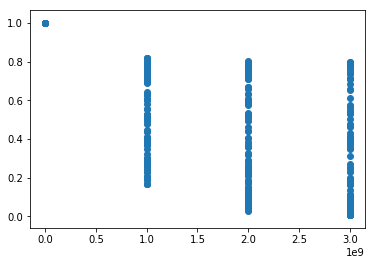

In [5]:
#add some parameters for the simulated ball-stick voxel 
mu = (2, 2) 
lambda_par = 1.7e-9  # in m^2/s
lambda_iso = 2.5e-9  # in m^2/s
f_0 = 0.2
f_1 = 0.8

parameter_vector = ballstick.parameters_to_parameter_vector(
    C1Stick_1_mu = mu,
    C1Stick_1_lambda_par=lambda_par, 
    G1Ball_1_lambda_iso=lambda_iso,
    partial_volume_0 = f_0,
    partial_volume_1 = f_1)

#simulate a single voxel
nmeas = len(acq_scheme.bvalues)
E = ballstick.simulate_signal(acq_scheme, parameter_vector)

       
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots()
axs.scatter(acq_scheme.bvalues, E) 
        
        

In [6]:
#least squares fit of the single ball-stick voxel to check everything is working
res = ballstick.fit(acq_scheme, E)
print(res.fitted_parameters_vector)
print(parameter_vector)
print(ballstick.parameter_names)

Setup brute2fine optimizer in 0.27991294860839844 seconds
Fitting of 1 voxels complete in 0.5611040592193604 seconds.
Average of 0.5611040592193604 seconds per voxel.
[[2.28355903e-09 1.70786074e-09 2.00001918e+00 2.00002749e+00
  2.01696458e-01 7.98303542e-01]]
[2.5e-09 1.7e-09 2.0e+00 2.0e+00 2.0e-01 8.0e-01]
['G1Ball_1_lambda_iso', 'C1Stick_1_lambda_par', 'C1Stick_1_mu', 'partial_volume_0', 'partial_volume_1']


In [7]:
ballstick.parameter_ranges

OrderedDict([('G1Ball_1_lambda_iso', (0.1, 3)),
             ('C1Stick_1_lambda_par', (0.1, 3)),
             ('C1Stick_1_mu',
              ([0, 3.141592653589793],
               [-3.141592653589793, 3.141592653589793])),
             ('partial_volume_0', (0.01, 0.99)),
             ('partial_volume_1', (0.01, 0.99))])

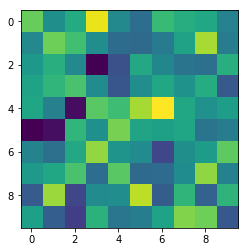

In [8]:
#simulate a simple image

dimx=10
dimy=10
simimg = np.zeros((dimx,dimy,len(E)))

for x in range(0,dimx):
    for y in range(0,dimy):
        simimg[x,y,:] = E + np.random.normal(0,0.01,nmeas) 
        
        
plt.imshow(simimg[:,:,0])




#more interesting image

dimx=10
dimy=10
simimg = np.zeros((dimx,dimy,len(E)))
nparam=6
param_map = np.zeros((dimx,dimy,nparam))

#mu_min = np.array([0.1,-np.pi])
#mu_max = np.array([np.pi-0.1,np.pi])

mu_min = np.array([1.5,2])
mu_max = np.array([1.5,2])

lambda_par_min = 1e-9
lambda_par_max = 2e-9

lambda_iso_min = 1.5e-9
lambda_iso_max = 3e-9

f_0_min = 0.1
f_0_max = 0.9

for x in range(0,dimx):
    for y in range(0,dimy):
        #random parameters
        #mu = np.random.uniform(low=[0,-np.pi],high=[np.pi,np.pi]) 
        #lambda_par = np.random.uniform(low=1e-9,high=2e-9) # in m^2/s
        #lambda_iso = np.random.uniform(low=1.5e-9,high=3e-9)  # in m^2/s
        #f_0 = np.random.uniform(low=0,high=1)
        
        #gradually changing parameters                
        mu = mu_min + [x/(dimx - 1),y/(dimy - 1)] * (mu_max - mu_min)        
        lambda_par = lambda_par_min + (x/(dimx-1)) * (lambda_par_max - lambda_par_min) # in m^2/s
        lambda_iso = lambda_iso_min + (y/(dimy-1)) * (lambda_iso_max - lambda_iso_min) # in m^2/s
        f_0 = f_0_min + (y/(2*(dimy-1))) * f_0_max + (x/(2*(dimx-1))) * (f_0_max - f_0_min)
        
        f_1 = 1-f_0

        parameter_vector = ballstick.parameters_to_parameter_vector(
            C1Stick_1_mu = mu,
            C1Stick_1_lambda_par=lambda_par, 
            G1Ball_1_lambda_iso=lambda_iso,
            partial_volume_0 = f_0,
            partial_volume_1 = f_1)

        #simulate this voxel
        nmeas = len(acq_scheme.bvalues)
        E = ballstick.simulate_signal(acq_scheme, parameter_vector)

        simimg[x,y,:] = E + np.random.normal(0,0.01,nmeas) 
        
        param_map[x,y,:]=[mu[0],mu[1],lambda_iso,lambda_par,f_0,f_1]
        
        




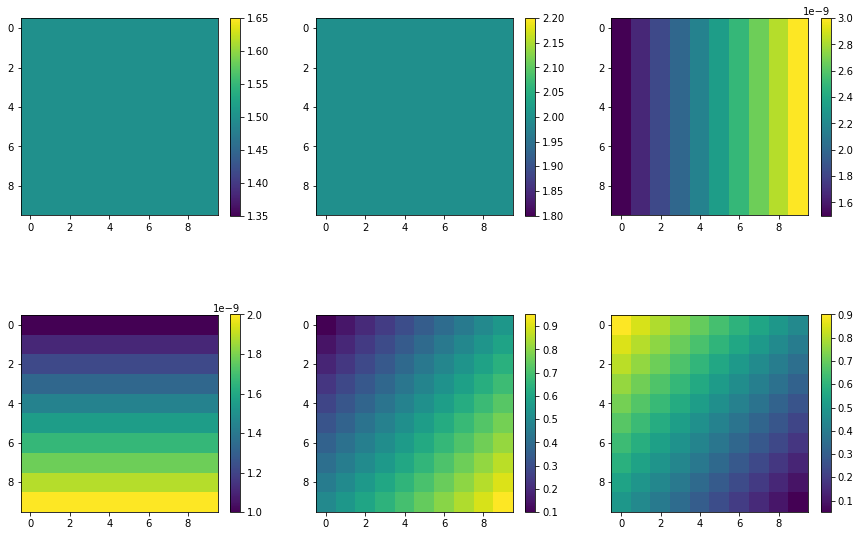

In [9]:
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

for p in range(0,nparam):
    colormap = axs[p].imshow(param_map[:,:,p])
    
    fig.colorbar(colormap, ax=axs[p], shrink=0.8)
    
    #axs[p].set_title(model.parameter_names[p])

In [10]:
param_map[:,:,4]

array([[0.1       , 0.15      , 0.2       , 0.25      , 0.3       ,
        0.35      , 0.4       , 0.45      , 0.5       , 0.55      ],
       [0.14444444, 0.19444444, 0.24444444, 0.29444444, 0.34444444,
        0.39444444, 0.44444444, 0.49444444, 0.54444444, 0.59444444],
       [0.18888889, 0.23888889, 0.28888889, 0.33888889, 0.38888889,
        0.43888889, 0.48888889, 0.53888889, 0.58888889, 0.63888889],
       [0.23333333, 0.28333333, 0.33333333, 0.38333333, 0.43333333,
        0.48333333, 0.53333333, 0.58333333, 0.63333333, 0.68333333],
       [0.27777778, 0.32777778, 0.37777778, 0.42777778, 0.47777778,
        0.52777778, 0.57777778, 0.62777778, 0.67777778, 0.72777778],
       [0.32222222, 0.37222222, 0.42222222, 0.47222222, 0.52222222,
        0.57222222, 0.62222222, 0.67222222, 0.72222222, 0.77222222],
       [0.36666667, 0.41666667, 0.46666667, 0.51666667, 0.56666667,
        0.61666667, 0.66666667, 0.71666667, 0.76666667, 0.81666667],
       [0.41111111, 0.46111111, 0.5111111

In [11]:
# #print(np.shape(fitted_parameters['partial_volume_1']))
# np.shape(np.ndarray.flatten(fitted_parameters['partial_volume_1']))

# mask=data_hcp[..., 0]>0

# np.shape(mask)

# # initial voxel-wise estimates from LSQ fits within the mask
# D0_init = fitted_parameters['C1Stick_1_lambda_par'][mask]
# D1_init = fitted_parameters['G1Ball_1_lambda_iso'][mask]
# f0_init = fitted_parameters['partial_volume_0'][mask]
# f1_init = fitted_parameters['partial_volume_1'][mask]
# stick_ori_init = fitted_parameters['C1Stick_1_mu'][mask]


# # flatten params to get [5 x nvox] array
# params_all = np.array([D0_init,
#                        D1_init,
#                        f0_init,
#                        stick_ori_init[:,0],
#                        stick_ori_init[:,1]])

np.random.uniform(low=[0,0],high=[1,1])

array([0.86489035, 0.73540918])

In [19]:
#Attempt at MCMC for a general microstructural model

import numpy as np
import scipy.stats
import copy
import matplotlib.pyplot as plt
import time
import math

#set up the model (this would be input to the function)
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
ballstick = MultiCompartmentModel(models=[ball,stick])

#these would be the inputs to the function
model = ballstick
acq_scheme = acq_scheme
data = simimg
mask = simimg[..., 0]>0

#do the model fit with least squares to get initial values
lsq_fit = model.fit(acq_scheme, data, mask=mask)

#rearrange the least squares fitted parameters into initial arrays for the MCMC
lsq_fitted_parameters = lsq_fit.fitted_parameters

lsq_fit.fitted_parameters.keys()

#initial voxel-wise estimates from LSQ fits within the mask
#original
#D0_init = lsq_fitted_parameters['C1Stick_1_lambda_par'][mask]
#D1_init = lsq_fitted_parameters['G1Ball_1_lambda_iso'][mask]
#f0_init = lsq_fitted_parameters['partial_volume_0'][mask]
#f1_init = lsq_fitted_parameters['partial_volume_1'][mask]
#stick_ori_init = lsq_fitted_parameters['C1Stick_1_mu'][mask]
#for general model - using model.parameter_names
#initialise dictionary
init_param=dict.fromkeys(model.parameter_names)
for param in model.parameter_names:
    init_param[param] = lsq_fitted_parameters[param][mask]
    

# original - flatten params to get [5 x nvox] array
#params_all = np.array([D0_init,
#                       D1_init,
#                       f0_init,
#                       stick_ori_init[:,0],
#                      stick_ori_init[:,1]])

# general model - flatten params to get [nparam x nvox] array, with paramters in the correct order
#get the total number of independent parameters - accounting for both orientation parameters 
all_model_param_names = '\t'.join(model.parameter_names)
n_orient_params = all_model_param_names.count('_mu')
nparam = len(model.parameter_names) + n_orient_params 

#one of the volume fractions for multi-compartment models is not independent
#if allparam_names.count('partial_volume')==0:
#    ncomp=1
#else:
#    ncomp = allparam_names.count('partial_volume')
#nparam = len(model.parameter_names) + n_orient_params - (ncomp-1)


#extract some useful values
nvox = np.sum(mask)

params_all = np.empty([nparam,nvox])
#find the positions that are volume fractions
partial_volume_index = []

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        params_all[l:l+2,:] = np.transpose(init_param[param])
        l=l+2
    elif 'partial_volume_' in param: 
        partial_volume_index.append(l) #need to know the index of volume fractions for the MH proposal step
        
        params_all[l,:] = np.transpose(init_param[param])
        l=l+1       
    else: 
        params_all[l,:] = np.transpose(init_param[param])
        l=l+1

         

#get the initial E_sim, E_fit

#original
# dimx=nvox
# dimy=1
# nmeas = len(acq_scheme.bvalues)

# E_sim = np.zeros((dimx, dimy, nmeas))
# E_sim[:,0,:] = data[mask]

# E_fit = np.zeros((dimx, dimy, nmeas))
# for x in range(0, dimx):
#     for y in range(0,dimy):
#         # generate signal
#         #parameter_vector = model.parameters_to_parameter_vector(
#         #    C1Stick_1_mu=stick_ori_init[x,:],
#         #    C1Stick_1_lambda_par=D0_init[x],
#         #    G1Ball_1_lambda_iso=D1_init[x],
#         #    partial_volume_0=f0_init[x],
#         #    partial_volume_1=1 - f0_init[x])
        
#         E_fit[x, y, :] = model.simulate_signal(acq_scheme, parameter_vector)
  
    
#for general model - change so that E_sim, E_fit are 2D instead of 3D

#measured signal
dimx=nvox
dimy=1
nmeas = len(acq_scheme.bvalues)
E_sim = np.zeros((dimx, dimy, nmeas))
E_sim[:,0,:] = data[mask]

#E_sim = np.zeros((nvox, nmeas))
#E_sim = data[mask]

E_fit = np.zeros((nvox, nmeas))
for i in range(0,nvox):
    parameter_vector = params_all[:,i]
        
    E_fit[i,:] = model.simulate_signal(acq_scheme, parameter_vector)

        
        
# initialise sigma
sigma = np.cov(params_all)

# TO DO: tune weights for Metropolis-Hastings parameter sampling (f, D, D* from Orton, orientations guessed)
#w = [.5e-10, .2e-10, .01, .01, .01, .01]
#initialise weights by approximating the scale of the parameter
w = 0.01 * np.mean(abs(params_all),axis=1)


nMCMCsteps = 100
#T = compute_temp_schedule(2000, 10**-3, nMCMCsteps)

#Accepted = 1
#Acceptance_rate = []
#Acceptance_rate.append(Accepted)

tmppar = np.zeros((nvox, nMCMCsteps, nparam))
tmpgibbs = np.zeros((nparam, nMCMCsteps))

# NB i (voxel loop) and j (MC loop) in keeping with Orton paper
for j in range(0, nMCMCsteps):
    print(j)
    it = j+1
    # Gibbs moves to update priors
    # sample mu from multivariate normal distribution defined by current parameter estimates
    m = np.mean(params_all, axis=1)
    V = sigma / nvox
    mu = np.random.multivariate_normal(m, V)
    
    #original
    #mu_scaled = mu * [1e9, 1e9, 1, 1, 1]
    #use inbuilt dmipy scalings
    mu_scaled= mu * model.scales_for_optimization
    
    # sample sigma from inverse Wishart distribution (using newly updated mu)
    # NB scaled parameters used in calculation of priors in Metropolis-Hastings updates
    phi = np.sum([np.outer(params_all[:, i]-mu,
                    params_all[:, i]-mu)
                for i in range(0, nvox)], axis=0)
    
    phi_scaled = np.sum([np.outer((params_all[:, i] - mu)*model.scales_for_optimization,
                                (params_all[:, i] - mu)*model.scales_for_optimization)
                        for i in range(0, nvox)], axis=0)
    
    #sigma = scipy.stats.invwishart(scale=phi, df=nvox-nparam).rvs()
    
    sigma_scaled = scipy.stats.invwishart(scale=phi_scaled, df=nvox-nparam).rvs()

    # Metropolis-Hastings parameter updates
    params_all_new = copy.copy(params_all)
    for i in range(0, nvox):       
        for p in range(nparam):  # loop over parameters
            #p = 0  # for now just look at
            # sample parameter
            params_all_new[p, i] = np.random.normal(params_all[p, i], w[p])
            if i == 0:
                print([params_all_new[p, i], params_all[p, i]])
            
            # compute acceptance
            y_i = copy.copy(E_sim[i, ])                                                    # actual measured signal
            g_i = copy.copy(E_fit[i, ])                                                    # model-predicted signal (old params)
            #original
            #parameter_vector = model.parameters_to_parameter_vector(
            #    C1Stick_1_mu=[params_all_new[3, i], params_all_new[4, i]],
            #    C1Stick_1_lambda_par=params_all_new[0, i],
            #    G1Ball_1_lambda_iso=params_all_new[1, i],
            #    partial_volume_0=params_all_new[2, i],
            #    partial_volume_1=1-params_all_new[2, i])

            #general model
            parameter_vector = params_all[:,i]                
            g_i_new = model.simulate_signal(acq_scheme, parameter_vector)   # model-predicted signal (new params)
            
            # calculate posteriors and PDFs (log scale)
            likelihood = (-nmeas / 2) * np.log(np.inner(y_i, y_i) -
                                            ((np.inner(y_i, g_i)) ** 2 / np.inner(g_i, g_i)))
            likelihood_new = (-nmeas / 2) * np.log(np.inner(y_i, y_i) -
                                                (np.inner(y_i, g_i_new) ** 2 / np.inner(g_i_new, g_i_new)))

          
            # both priors are the same without scaling
            prior = np.log(scipy.stats.multivariate_normal.pdf(params_all[:, i], mu, sigma, allow_singular=1))
            prior_new = np.log(scipy.stats.multivariate_normal.pdf(params_all_new[:, i], mu, sigma, allow_singular=1))
            # scaling parameters helps
            prior_scaled = np.log(scipy.stats.multivariate_normal.pdf(params_all[:, i] * model.scales_for_optimization,
                                                                    mu_scaled, sigma_scaled, allow_singular=1))
            prior_new_scaled = np.log(scipy.stats.multivariate_normal.pdf(params_all_new[:, i] * model.scales_for_optimization,
                                                                        mu_scaled, sigma_scaled, allow_singular=1))
            

            alpha = np.min([0, (likelihood_new + prior_new) - (likelihood + prior)])
            alpha_scaled = np.min([0, (likelihood_new + prior_new_scaled) - (likelihood + prior_scaled)] )
            r = np.log(np.random.uniform(0, 1))

            # reject new parameter value if criteria not met
            if r < alpha_scaled:
                #Accepted +=1
                params_all[p, i] = copy.copy(params_all_new[p, i])
                E_fit[i, ] = copy.copy(g_i_new)
            # else:
            #     if Accepted/(it*nvox) < 0.23:
            #         continue
                    # print("Stopping criterion met {}".format(Accepted/(it*nvox)))
                    # return Acceptance_rate

            # for plotting
            tmppar[i, j, p] = copy.copy(params_all[p, i])
            tmpgibbs[:, j] = mu

            #Acceptance_rate.append(Accepted/(it*nvox) )
            
            
            
            
#put the MCMC chains back into an image
#initialise a dictionary, each entry will be the map for one parameter
bayesian_fit_maps = dict.fromkeys(model.parameter_names)

# for p in range(nparam):
#     this_param_map = np.zeros(np.shape(mask))
#     this_param_map[mask] = params_all[p,:]
    
#     bayesian_fit_maps[model.parameter_names[p]] = this_param_map
    
    
l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps in the final dimension
        this_param_map = np.zeros(np.shape(mask) + (2,))
        
        this_param_map[mask,0] = params_all[l,:]
        this_param_map[mask,1] = params_all[l+1,:]
    
        bayesian_fit_maps[param] = this_param_map
        
        l=l+2
    else: 
        this_param_map = np.zeros(np.shape(mask))
        this_param_map[mask] = params_all[l,:]
    
        bayesian_fit_maps[param] = this_param_map
            
        l=l+1
        
    





We highly recommend installing pathos to take advantage of multicore processing.
Setup brute2fine optimizer in 0.2972550392150879 seconds
Fitting of 100 voxels complete in 2.3914740085601807 seconds.
Average of 0.023914740085601807 seconds per voxel.
0
[1.5890258844366116e-09, 1.6205432631965598e-09]
[1.0026437658712566e-09, 1.001723757301743e-09]
[1.634871430357281, 1.6409032793618894]
[-1.1429343895058808, -1.142519590559217]
[0.09564757445271542, 0.09767260652965173]
[0.8989602065622552, 0.9023273934703483]
1
[1.6229135065753114e-09, 1.5890258844366116e-09]
[1.0258433142296068e-09, 1.0026437658712566e-09]
[1.633545486874218, 1.6409032793618894]
[-1.1515926296603227, -1.142519590559217]
[0.1019200532867266, 0.09767260652965173]
[0.9080740219815759, 0.9023273934703483]
2
[1.5991677949067209e-09, 1.6229135065753114e-09]
[1.0458146459727982e-09, 1.0258433142296068e-09]
[1.64951454655148, 1.6409032793618894]
[-1.155815185191604, -1.142519590559217]
[0.09546439179392159, 0.097672606529651

30
[1.6323303289696195e-09, 1.6229135065753114e-09]
[1.0124851907050182e-09, 1.0258433142296068e-09]
[1.6804947486151962, 1.6409032793618894]
[-1.1608631613528007, -1.142519590559217]
[0.0967957178987664, 0.09767260652965173]
[0.9008231734746313, 0.9023273934703483]
31
[1.6308386612207945e-09, 1.6229135065753114e-09]
[1.0235237785220738e-09, 1.0258433142296068e-09]
[1.635416979670224, 1.6409032793618894]
[-1.1327595313419174, -1.142519590559217]
[0.1000071906466415, 0.09767260652965173]
[0.899391740552111, 0.9023273934703483]
32
[1.6195928058757183e-09, 1.6229135065753114e-09]
[1.0605950755648725e-09, 1.0258433142296068e-09]
[1.6306685821241809, 1.6409032793618894]
[-1.1649429844105843, -1.142519590559217]
[0.0919599924473594, 0.09767260652965173]
[0.8991415630099416, 0.9023273934703483]
33
[1.6245616196995976e-09, 1.6229135065753114e-09]
[9.96425189302116e-10, 1.0258433142296068e-09]
[1.6564678274252678, 1.6409032793618894]
[-1.1529729535756892, -1.142519590559217]
[0.1016887284806856

61
[1.6181479847762353e-09, 1.6229135065753114e-09]
[1.0303458231504523e-09, 1.0258433142296068e-09]
[1.6429008680400614, 1.6409032793618894]
[-1.1594530473064772, -1.142519590559217]
[0.10493436734970633, 0.09767260652965173]
[0.9007159270410527, 0.9023273934703483]
62
[1.6404199258586124e-09, 1.6229135065753114e-09]
[1.0027296511951254e-09, 1.0258433142296068e-09]
[1.627436399782843, 1.6409032793618894]
[-1.1628507578902574, -1.142519590559217]
[0.09674388115823375, 0.09767260652965173]
[0.8978336665384138, 0.9023273934703483]
63
[1.601592104163149e-09, 1.6229135065753114e-09]
[9.992795880651558e-10, 1.0258433142296068e-09]
[1.6508763601141856, 1.6409032793618894]
[-1.1569835989197066, -1.142519590559217]
[0.09686769784302103, 0.09767260652965173]
[0.9093874913735153, 0.9023273934703483]
64
[1.6350941941259126e-09, 1.6229135065753114e-09]
[1.0177099051259346e-09, 1.0258433142296068e-09]
[1.6410112953048852, 1.6409032793618894]
[-1.1376833148454717, -1.142519590559217]
[0.108846996892

92
[1.616861607805504e-09, 1.6229135065753114e-09]
[1.0115004553698595e-09, 1.0258433142296068e-09]
[1.650531093319846, 1.6409032793618894]
[-1.1521014244087413, -1.142519590559217]
[0.09630209583304035, 0.09767260652965173]
[0.908451135943972, 0.9023273934703483]
93
[1.6142204237781752e-09, 1.6229135065753114e-09]
[1.0227676887173705e-09, 1.0258433142296068e-09]
[1.6421743490410026, 1.6409032793618894]
[-1.134193567924764, -1.142519590559217]
[0.09638790314879565, 0.09767260652965173]
[0.9130554326044888, 0.9023273934703483]
94
[1.58263515686267e-09, 1.6229135065753114e-09]
[9.97021998082532e-10, 1.0258433142296068e-09]
[1.643530732591078, 1.6409032793618894]
[-1.134824065770311, -1.142519590559217]
[0.09952983058760585, 0.09767260652965173]
[0.9062090742283855, 0.9023273934703483]
95
[1.6588022919231492e-09, 1.6229135065753114e-09]
[1.0372933185424949e-09, 1.0258433142296068e-09]
[1.6163048993139395, 1.6409032793618894]
[-1.1297841947855944, -1.142519590559217]
[0.0879818452428708, 0

In [ ]:
l

In [ ]:
model.parameter_names

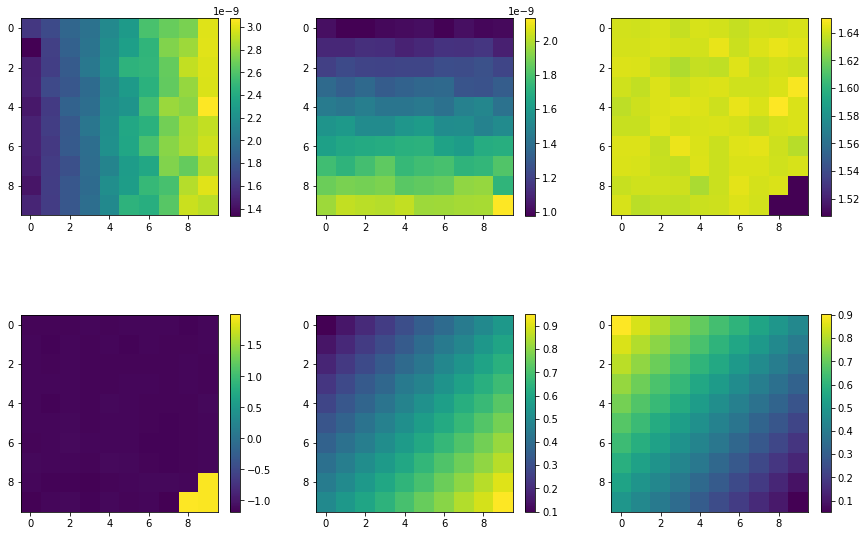

In [20]:
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

# l=0
# for p in range(0,nparam):
#     colormap = axs[p].imshow(bayesian_fit_maps[model.parameter_names[p]])        
    
#     fig.colorbar(colormap, ax=axs[p], shrink=0.8)
    
#     #axs[p].set_title(model.parameter_names[p])    
    
        
l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps in the final dimension
        colormap = axs[l].imshow(bayesian_fit_maps[param][...,0])        
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        l=l+1
        
        colormap = axs[l].imshow(bayesian_fit_maps[param][...,1])        
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        l=l+1

    else: 
        colormap = axs[l].imshow(bayesian_fit_maps[param])        
    
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
            
        l=l+1


In [ ]:
bayesian_fit_maps['partial_volume_1']+bayesian_fit_maps['partial_volume_0']

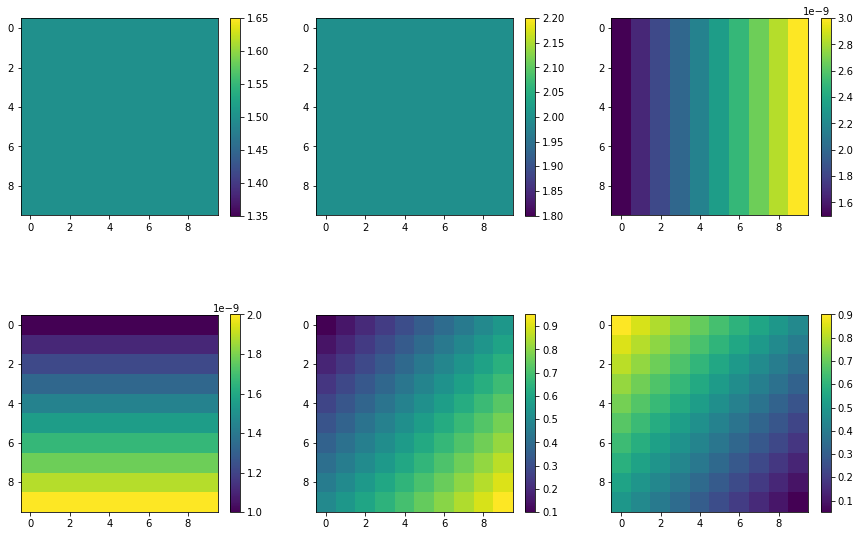

In [16]:
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

for p in range(0,nparam):
    colormap = axs[p].imshow(param_map[:,:,p])
    
    fig.colorbar(colormap, ax=axs[p], shrink=0.8)
    
    #axs[p].set_title(model.parameter_names[p])

    
    

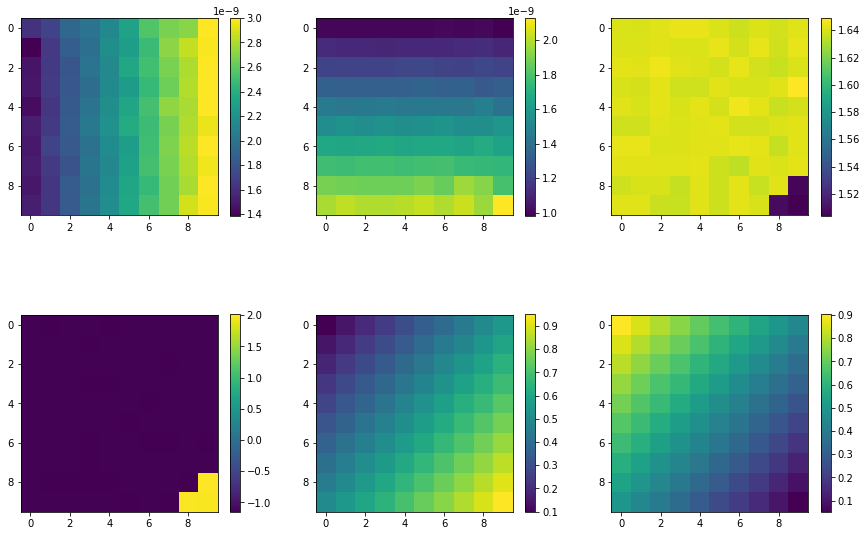

In [17]:
fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

l=0
for param in model.parameter_names:
    if '_mu' in param: #if an orientation parameter
        #two maps in the final dimension
        colormap = axs[l].imshow(lsq_fit.fitted_parameters[param][...,0])        
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        l=l+1
        
        colormap = axs[l].imshow(lsq_fit.fitted_parameters[param][...,1])        
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
        l=l+1

    else: 
        colormap = axs[l].imshow(lsq_fit.fitted_parameters[param])        
    
        fig.colorbar(colormap, ax=axs[l], shrink=0.8)
            
        l=l+1
        
        
        

    


In [ ]:
model.parameter_names

In [ ]:
lsq_fit.fitted_parameters.keys()

In [ ]:
from IPython.display import Image
model.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=[10, 10])
axs = axs.ravel()

for i in range(0,5):
    axs[i].plot(tmpgibbs[i,:])






In [ ]:
np.shape(tmppar)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=[10, 10])
axs = axs.ravel()

voxel_index=0
for i in range(0,5):
    axs[i].plot(tmppar[voxel_index,:,i])

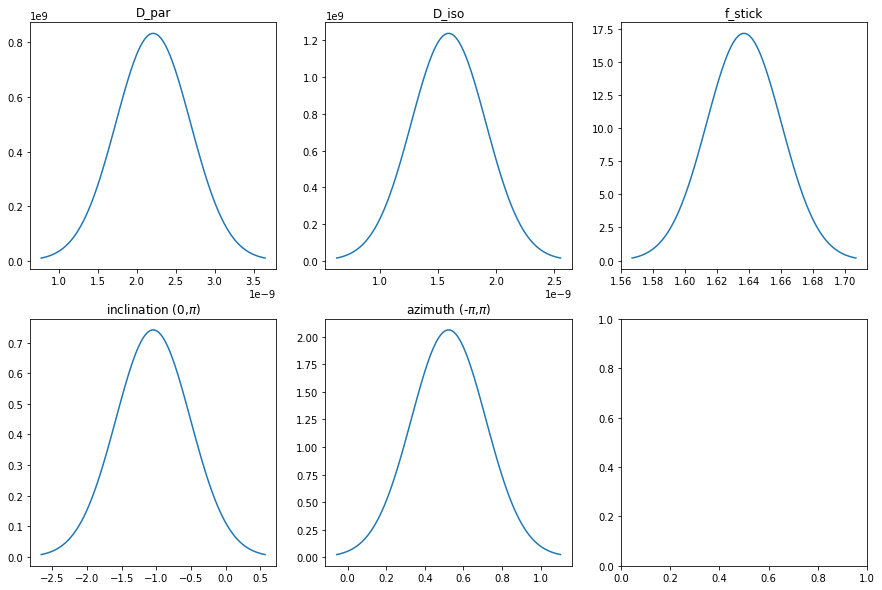

In [18]:
import scipy.stats as stats

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

names = ['D_par','D_iso','f_stick','inclination (0,$\pi$)','azimuth (-$\pi$,$\pi$)']


for i in range(0,5):
    marginal_mu = mu[i]
    variance = sigma[i,i]
    marginal_sigma = math.sqrt(variance)
    x = np.linspace(marginal_mu - 3*marginal_sigma, marginal_mu + 3*marginal_sigma, 100)
    axs[i].plot(x, stats.norm.pdf(x, marginal_mu, marginal_sigma))
    axs[i].set_title(names[i])

In [ ]:
#%run MCMC



In [ ]:
plt.plot(tmpgibbs[0,:])

In [ ]:
plt.plot(tmppar[1,:])

In [ ]:
np.shape(tmppar)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
fig, axs = plt.subplots()
axs.plot(tmppar[3,:]) 


In [ ]:
np.shape(tmppar[1,:])